# Churn Analysis


**Dataset Info:**
Sample Data Set containing Telco customer data and showing customers left last month

In [83]:
#import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)


In [84]:
#Loading the Dataset
telco_base_data = pd.read_csv(r"C:\Users\IBMR\Downloads\Churn_Model.csv")

In [85]:
telco_base_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Check the various attributes of data like shape (rows and cols), Columns, datatypes

In [86]:
telco_base_data.shape

(7043, 21)

In [87]:
telco_base_data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [88]:
# Checking the data types of all the columns
telco_base_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

* Total Charges should be in numbers. but here it is in string data type.
* SeniorCitizen is categorical value but it is in numeric.


In [89]:
# Check the descriptive statistics of numeric variables
telco_base_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


SeniorCitizen is actually a categorical hence the 25%-50%-75% distribution is not propoer

75% customers have tenure less than 55 months

Average Monthly charges are USD 64.76 whereas 25% customers pay more than USD 89.85 per month

Text(0.5, 1.02, 'Count of TARGET Variable per category')

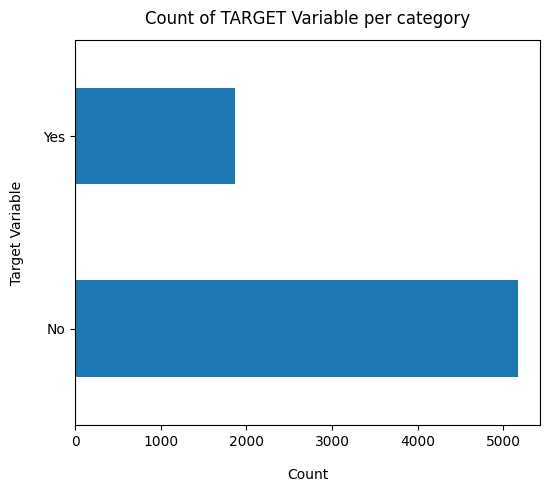

In [90]:
telco_base_data['Churn'].value_counts().plot(kind='barh', figsize=(6, 5))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02)

In [91]:
100*telco_base_data['Churn'].value_counts()/len(telco_base_data['Churn'])

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

In [92]:
telco_base_data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

* Data is highly imbalanced, ratio = 73:27<br>
* So we analyse the data with other features while taking the target values separately to get some insights.

In [93]:
# Concise Summary of the dataframe, as we have too many columns, we are using the verbose = True mode
telco_base_data.info(verbose = True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


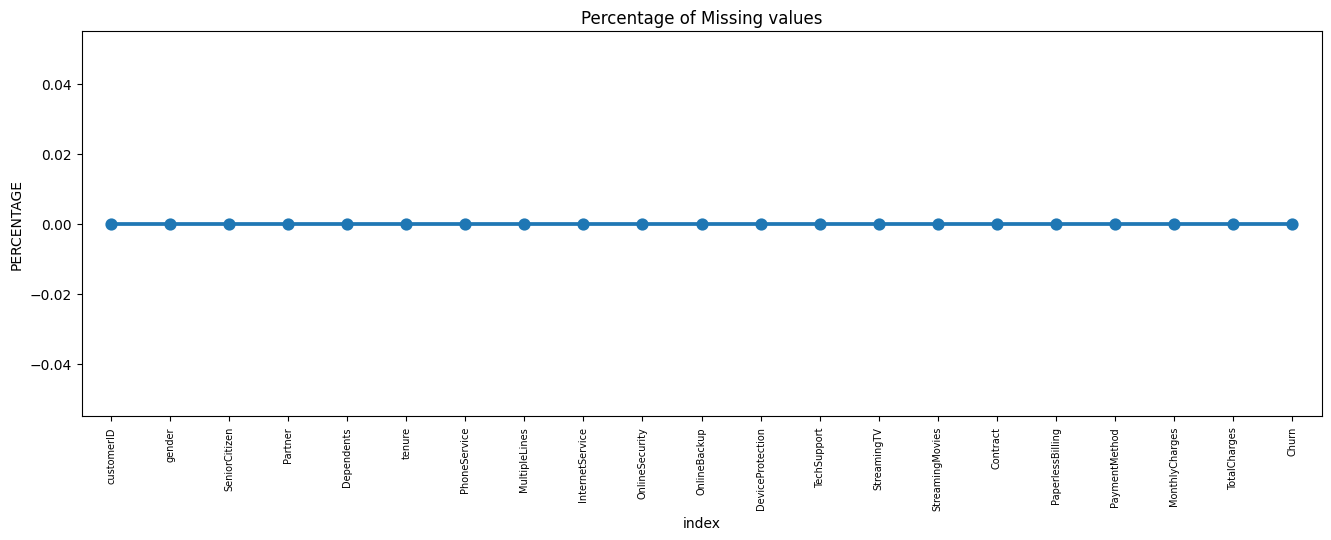

In [94]:
missing = pd.DataFrame((telco_base_data.isnull().sum())*100/telco_base_data.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index',y=0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

* Here, we don't have any missing data.

## Data Cleaning


**1.** Create a copy of base data for manupulation & processing

In [95]:
telco_data = telco_base_data.copy()

**2.** Total Charges should be numeric amount. Let's convert it to numerical data type

In [96]:
telco_data.TotalCharges = pd.to_numeric(telco_data.TotalCharges, errors='coerce')
telco_data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

**3.** As we can see there are 11 missing values in TotalCharges column. Let's check these records 

In [97]:
telco_data.loc[telco_data ['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


**4. Missing Value Treatement**

Since the % of these records compared to total dataset is very low ie 0.15%, it is safe to ignore them from further processing.

In [98]:
#Removing missing values 
telco_data.dropna(how = 'any', inplace = True)

**5.** Divide customers into bins based on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [99]:
# Get the max tenure
print(telco_data['tenure'].max()) #72

72


In [100]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)

In [101]:
telco_data['tenure_group'].value_counts()

tenure_group
1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: count, dtype: int64

**6.** Remove columns not required for processing

In [102]:
#drop column customerID and tenure
telco_data.drop(columns= ['customerID','tenure'], axis=1, inplace=True)
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


## Data Exploration
**1.** Plot distibution of individual predictors by churn

### Univariate Analysis

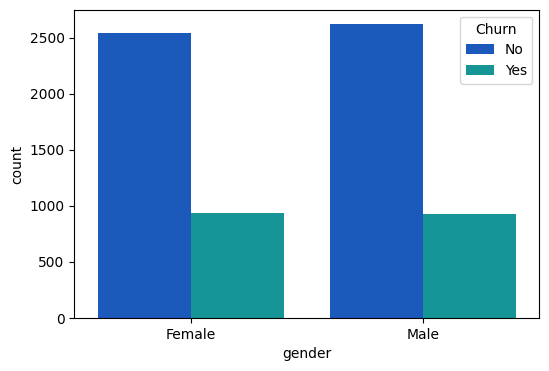

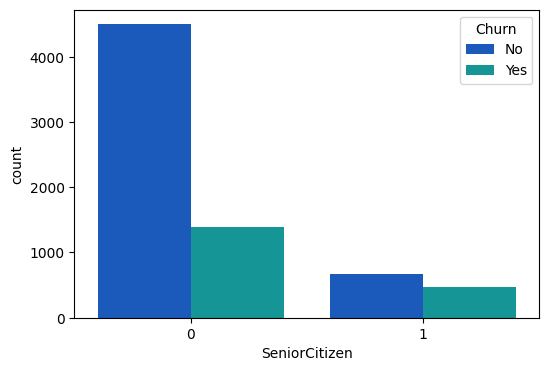

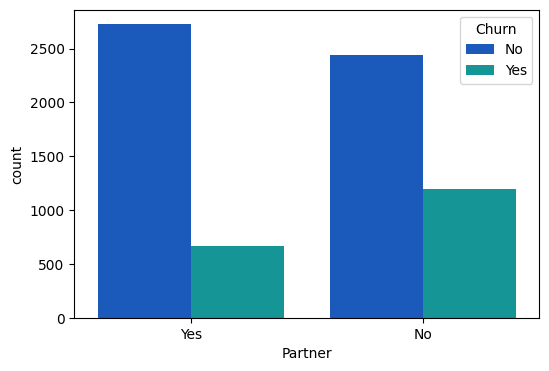

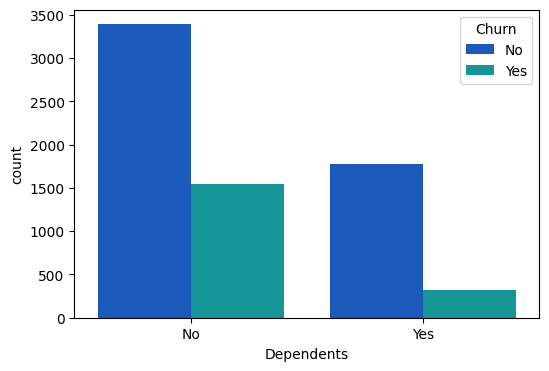

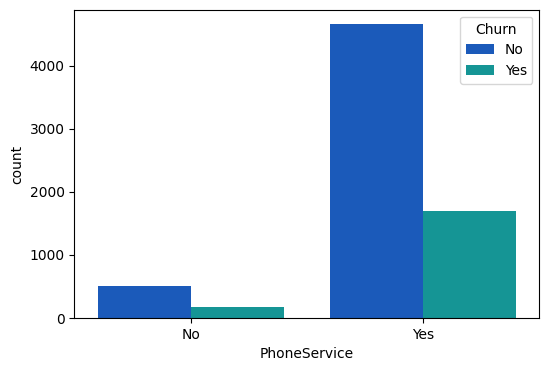

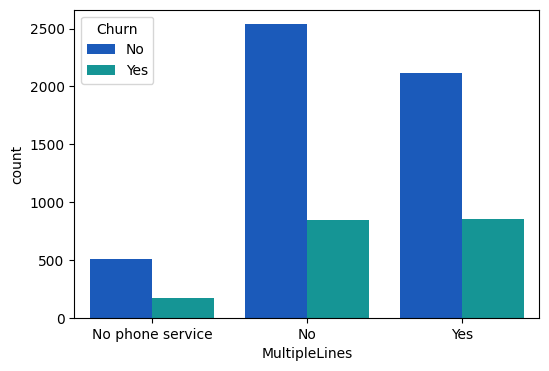

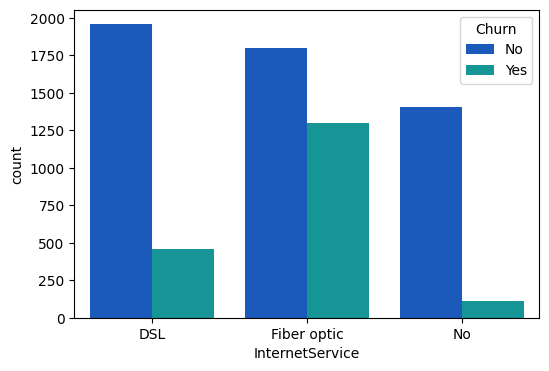

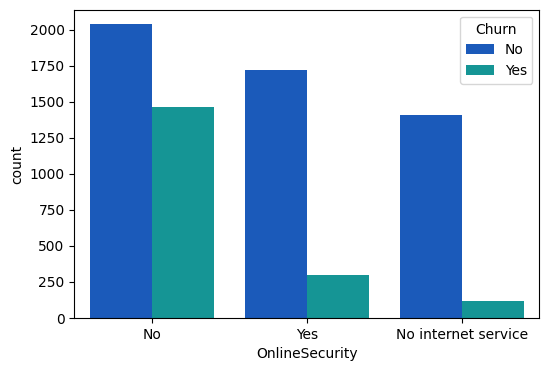

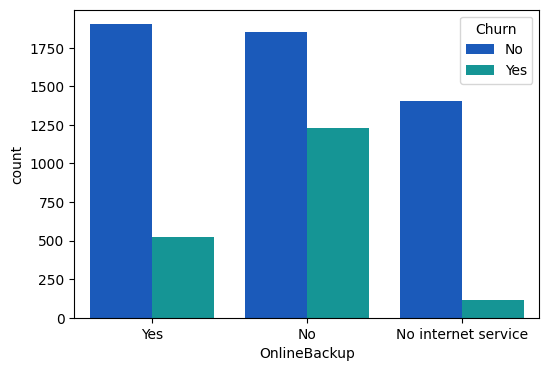

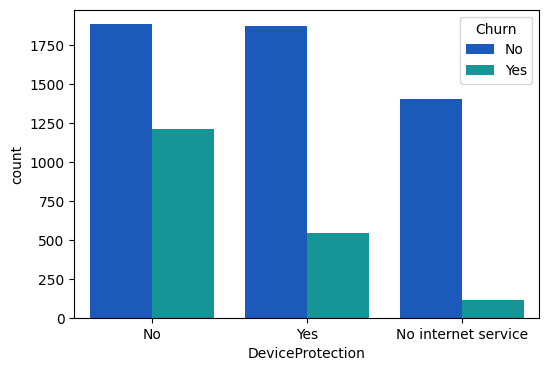

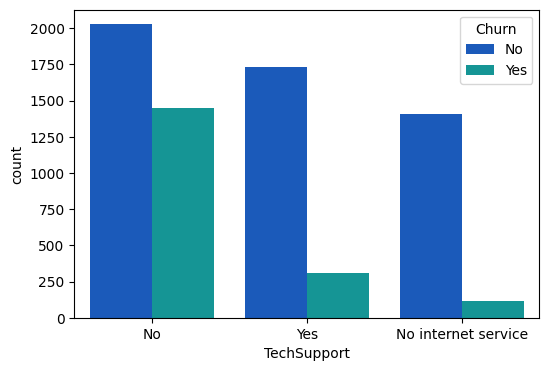

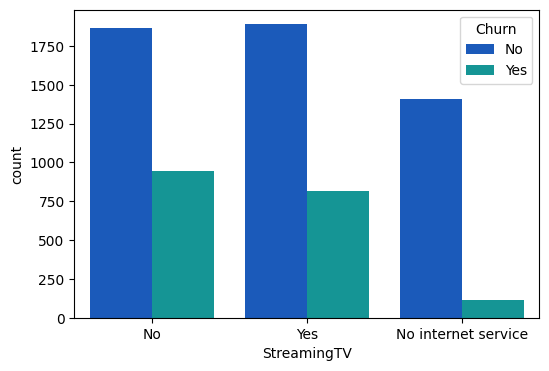

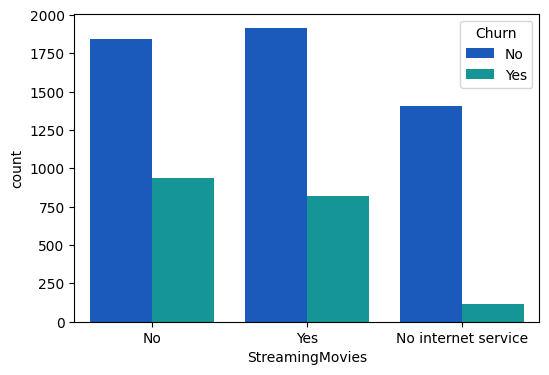

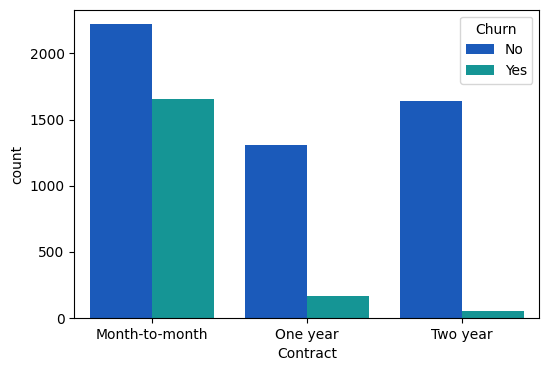

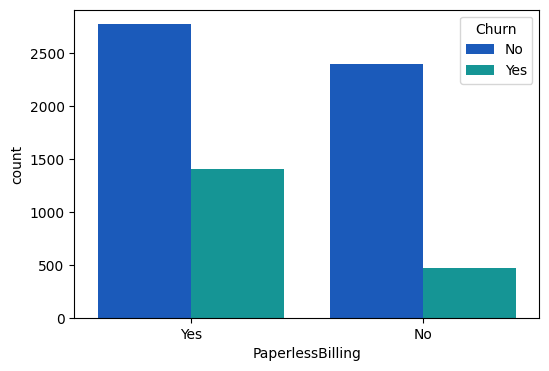

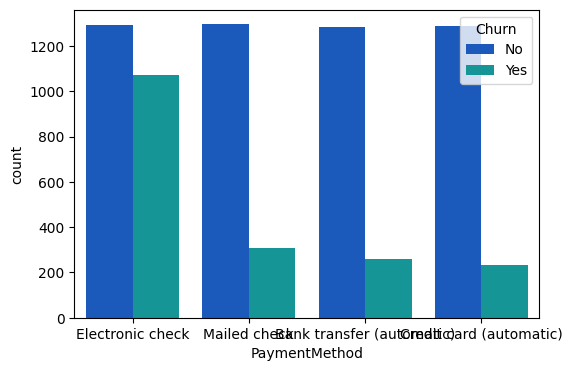

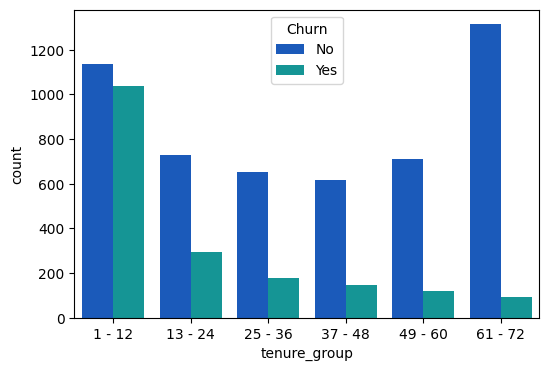

In [103]:
for i, predictor in enumerate(telco_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i,figsize=(6,4))
    sns.countplot(data=telco_data, x=predictor, hue='Churn',palette="winter")

**2.** Convert the target variable 'Churn'  in a binary numeric variable i.e. Yes=1 ; No = 0

In [104]:
telco_data['Churn'] = np.where(telco_data.Churn == 'Yes',1,0)

In [105]:
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


**3.** Convert all the categorical variables into dummy variables

In [106]:
telco_data_dummies = pd.get_dummies(telco_data)
telco_data_dummies = telco_data_dummies.astype(int)
telco_data_dummies.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29,29,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0


**4.** Relationship between Monthly Charges and Total Charges

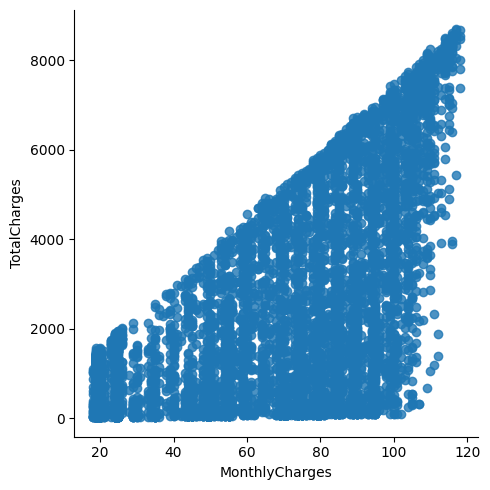

In [107]:
sns.lmplot(data=telco_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

Total Charges increase as Monthly Charges increase - as expected.

**5.** Churn by Monthly Charges and Total Charges

Text(0.5, 1.0, 'Monthly charges by churn')

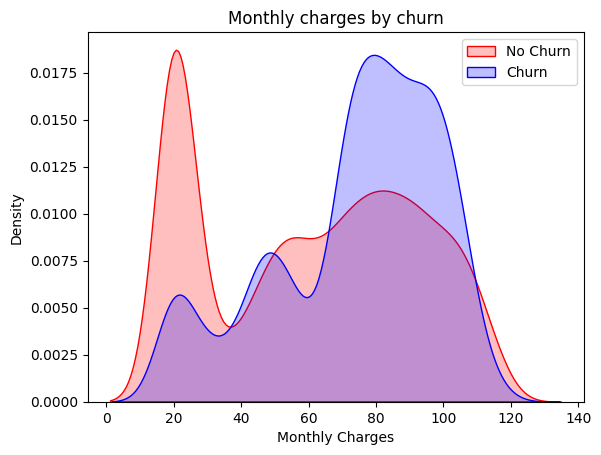

In [108]:
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0)],
                color="Red", shade = True)
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1)],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

**Insight:** Churn is high when Monthly Charges ar high

Text(0.5, 1.0, 'Total charges by churn')

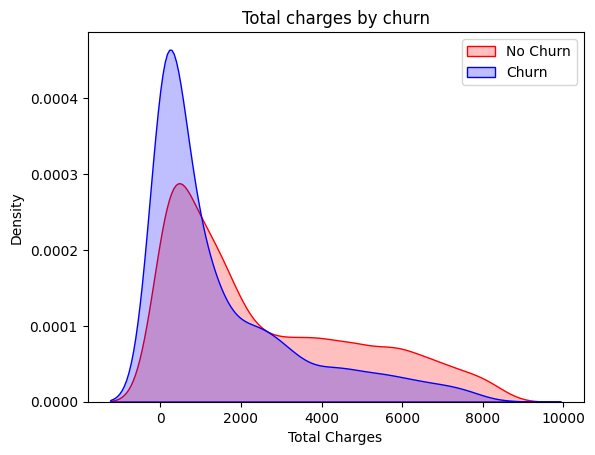

In [109]:
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

As we can see Higher Churn at lower Total Charges

However if we combine the insights of 3 parameters i.e. Tenure, Monthly Charges & Total Charges then the picture is bit clear :- Higher Monthly Charge at lower tenure results into lower Total Charge. Hence, all these 3 factors viz **Higher Monthly Charge**,  **Lower tenure** and **Lower Total Charge** are linkd to **High Churn**.

**11.** Build a corelation of all predictors with **'Churn'**

<Axes: >

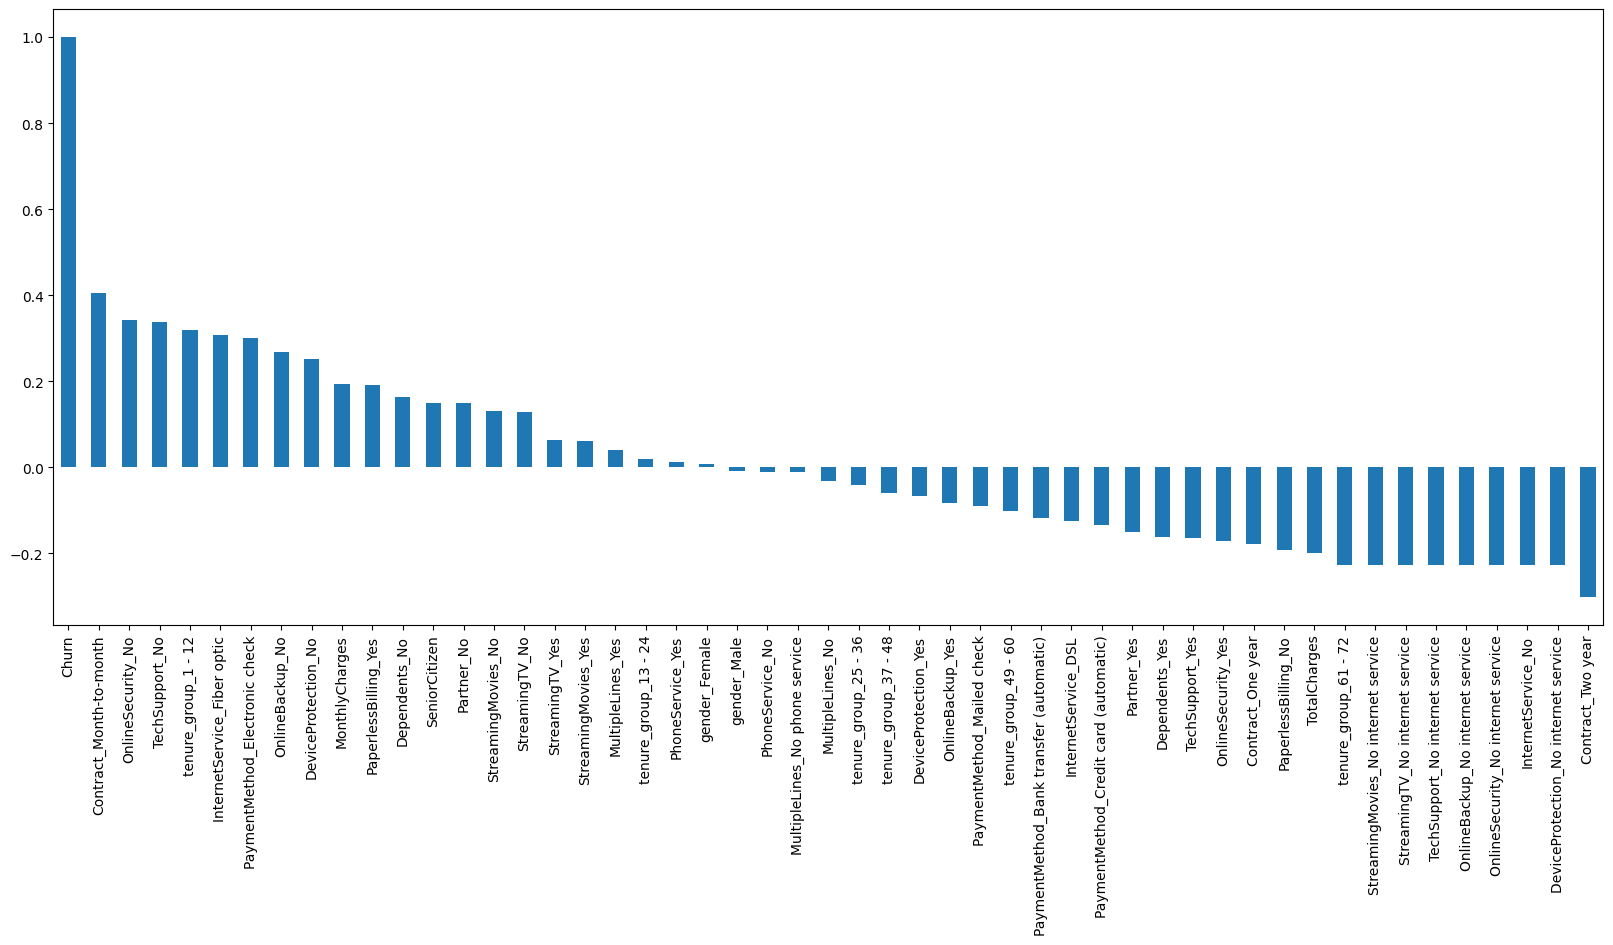

In [110]:
plt.figure(figsize=(20,8))
telco_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**Derived Insight:**

**HIGH** Churn seen in case of  **Month to month contracts**, **No online security**, **No Tech support**, **First year of subscription** and **Fibre Optics Internet**

**LOW** Churn is seens in case of **Long term contracts**, **Subscriptions without internet service** and **The customers engaged for 5+ years**

Factors like **Gender**, **Availability of PhoneService** and **# of multiple lines** have alomost **NO** impact on Churn

This is also evident from the **Heatmap** below

<Axes: >

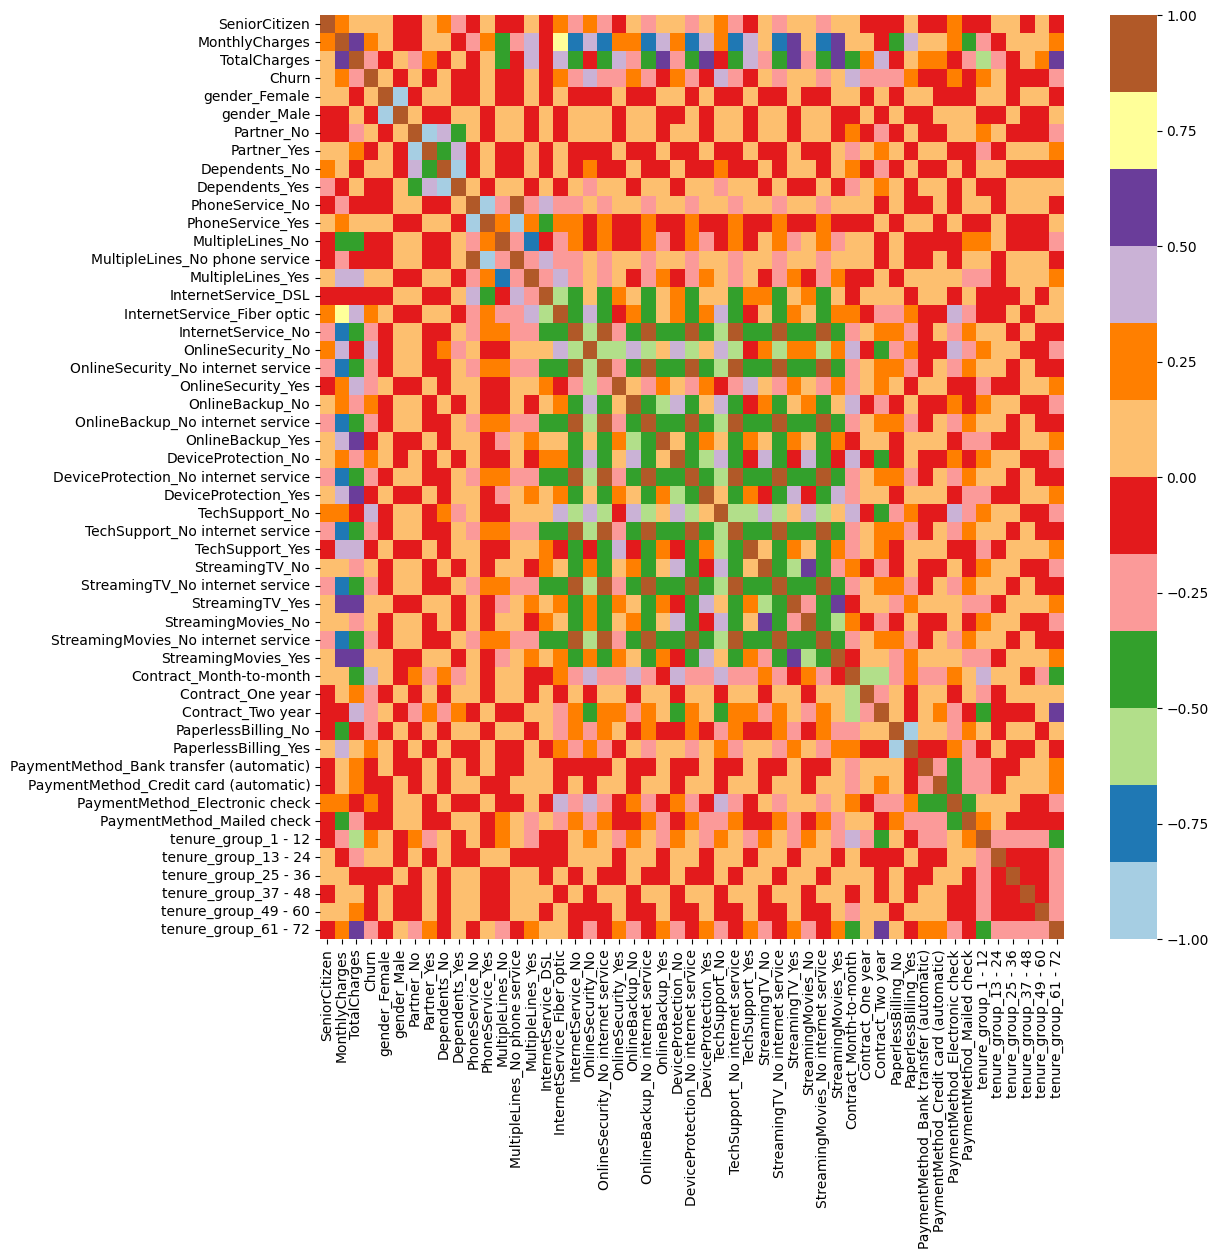

In [111]:
plt.figure(figsize=(12,12))
sns.heatmap(telco_data_dummies.corr(), cmap="Paired")

### Model Building

In [112]:
# Use Different variable
df =telco_data_dummies
df

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29,29,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84,1990,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0
7039,0,103,7362,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
7040,0,29,346,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
7041,1,74,306,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0


In [113]:
x=df.drop('Churn',axis=1)
x

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29,29,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,53,108,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84,1990,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0
7039,0,103,7362,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
7040,0,29,346,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
7041,1,74,306,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0


In [114]:
y=df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int32

##### Train Test Split

In [115]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

####    Logistic Regression

In [116]:
model_lr = LogisticRegression()
model_lr.fit(x_test,y_test)

LogisticRegression()

In [117]:
y_pred_lr = model_lr.predict(x_test)

In [118]:
model_lr.score(x_test,y_test)

0.7981520966595593

In [119]:
print(classification_report(y_test, y_pred_lr, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.67      0.48      0.56       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.71      1407
weighted avg       0.79      0.80      0.79      1407



In [120]:
print(confusion_matrix(y_test,y_pred_lr))

[[945  88]
 [196 178]]


* As you can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.

* Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers.

* Hence, moving ahead to call SMOTEENN (UpSampling + ENN)

In [121]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(x,y)

In [122]:
xr_train_lr,xr_test_lr,yr_train_lr,yr_test_lr =train_test_split(X_resample, y_resample,test_size=0.2)

In [123]:
model_lr_smote=LogisticRegression()


In [124]:
model_lr_smote.fit(xr_train_lr,yr_train_lr)
yr_predict_lr = model_lr_smote.predict(xr_test_lr)
model_score_lr = model_lr_smote.score(xr_test_lr, yr_test_lr)
print(model_score_lr)
print(metrics.classification_report(yr_test_lr, yr_predict_lr))

0.9387402933563417
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       505
           1       0.95      0.94      0.95       654

    accuracy                           0.94      1159
   macro avg       0.94      0.94      0.94      1159
weighted avg       0.94      0.94      0.94      1159



In [125]:
print(metrics.confusion_matrix(yr_test_lr, yr_predict_lr))

[[474  31]
 [ 40 614]]


#### Decision Tree Classifier

In [126]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [127]:
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [128]:
y_pred_train = model_dt.predict(x_train)
y_pred=model_dt.predict(x_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [129]:
model_dt.score(x_test,y_test)


0.7697228144989339

In [130]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1033
           1       0.57      0.55      0.56       374

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



In [131]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x,y)

In [132]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)

In [133]:
model_dt_smote=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [134]:
model_dt_smote.fit(xr_train,yr_train)
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test, yr_test)
print(model_score_r)
print(metrics.classification_report(yr_test, yr_predict))

0.9323503902862099
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       545
           1       0.94      0.93      0.94       608

    accuracy                           0.93      1153
   macro avg       0.93      0.93      0.93      1153
weighted avg       0.93      0.93      0.93      1153



In [135]:
print(metrics.confusion_matrix(yr_test, yr_predict))

[[510  35]
 [ 43 565]]


*   Now we can see quite better results, i.e. Accuracy: 92 %, and a very good recall, precision & f1 score for minority class.

### Random Forest 

In [136]:
model_rf=RandomForestClassifier(n_estimators=200, criterion='entropy', random_state = 100,max_depth=6, min_samples_leaf=8)
model_rf.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=8,
                       n_estimators=200, random_state=100)

In [137]:
y_pred=model_rf.predict(x_test)

In [138]:
model_rf.score(x_test,y_test)

0.7846481876332623

In [139]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1033
           1       0.64      0.42      0.51       374

    accuracy                           0.78      1407
   macro avg       0.73      0.67      0.69      1407
weighted avg       0.77      0.78      0.77      1407



In [140]:
sm = SMOTEENN()
X_resampled1, y_resampled1 = sm.fit_resample(x,y)

In [141]:
xr_train1,xr_test1,yr_train1,yr_test1=train_test_split(X_resampled1, y_resampled1,test_size=0.2)

In [142]:
model_rf_smote=RandomForestClassifier(n_estimators=200, criterion='entropy', random_state = 100,max_depth=6, min_samples_leaf=8)

In [143]:
model_rf_smote.fit(xr_train1,yr_train1)

RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=8,
                       n_estimators=200, random_state=100)

In [144]:
yr_predict1 = model_rf_smote.predict(xr_test1)

In [145]:
model_score_r1 = model_rf_smote.score(xr_test1, yr_test1)
print(model_score_r1)
print(metrics.classification_report(yr_test1, yr_predict1))

0.9340277777777778
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       522
           1       0.91      0.97      0.94       630

    accuracy                           0.93      1152
   macro avg       0.94      0.93      0.93      1152
weighted avg       0.94      0.93      0.93      1152



In [146]:
print(metrics.confusion_matrix(yr_test1, yr_predict1))

[[464  58]
 [ 18 612]]


* With RF Classifier, also we are able to get quite good results, infact better than Decision Tree.

#### XGB Classifier


In [147]:
model_xgb=XGBClassifier()
model_xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [148]:
y_pred_xgb = model_xgb.predict(x_test)

In [149]:
model_xgb.score(x_test,y_test)

0.7690120824449183

In [150]:
sm2 = SMOTEENN()
X_resampled2, y_resampled2 = sm.fit_resample(x,y)


In [151]:
xr_train2,xr_test2,yr_train2,yr_test2=train_test_split(X_resampled2, y_resampled2,test_size=0.2)

In [152]:
model_xgb_smote=XGBClassifier(n_estimators=100,max_depth=6,random_state = 42)
model_xgb_smote.fit(xr_train2,yr_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [153]:
y_pre = model_xgb_smote.predict(xr_test2)

In [154]:
print(model_xgb_smote.score(xr_test2,yr_test2))

0.96280276816609


In [155]:

print(metrics.classification_report(yr_test2, y_pre))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       538
           1       0.96      0.97      0.97       618

    accuracy                           0.96      1156
   macro avg       0.96      0.96      0.96      1156
weighted avg       0.96      0.96      0.96      1156



Perform PCA

In [156]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(0.9)
xr_train_pca = pca.fit_transform(xr_train2)
xr_test_pca = pca.transform(xr_test2)
explained_variance = pca.explained_variance_ratio_

In [157]:
model=XGBClassifier(n_estimators=100,max_depth=6,random_state = 42)
model.fit(xr_train_pca,yr_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [158]:
yr_predict_pca = model.predict(xr_test_pca)

In [159]:
model_score_r_pca = model.score(xr_test_pca, yr_test2)

In [160]:
print(model_score_r_pca)
print(metrics.classification_report(yr_test2, yr_predict_pca))

0.7370242214532872
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       538
           1       0.74      0.79      0.76       618

    accuracy                           0.74      1156
   macro avg       0.74      0.73      0.73      1156
weighted avg       0.74      0.74      0.74      1156



##### With PCA, we couldn't see any better results, hence let's finalise the model which was created by XGB Classifier, and save the model so that we can use it in a later stage :)

#### Pickling the model

In [161]:
import pickle
filename = 'model.sav'

In [162]:
pickle.dump(model_xgb_smote, open(filename, 'wb'))

In [163]:
load_model = pickle.load(open(filename, 'rb'))

In [164]:
model_score = load_model.score(xr_test2, yr_test2)
model_score

0.96280276816609

Our final model  XGB Classifier with SMOTEENN, is now ready and dumped in model.sav, which we will use and prepare API's so that we can access our model from UI.